In [1]:
%pip install git+https://github.com/hmzbn/qemlib.git

  Cloning https://github.com/hmzbn/qemlib.git to /tmp/pip-req-build-2vjjmobs
  Running command git clone --filter=blob:none --quiet https://github.com/hmzbn/qemlib.git /tmp/pip-req-build-2vjjmobs
  Resolved https://github.com/hmzbn/qemlib.git to commit 22ecf4009f7d866bc8e902746bee4c3dd84ff203
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error

from qemlib.zne import run_zne


In [3]:
# Simple depolarizing noise
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(0.02, 1), ["rx", "rz", "sx"]
)

backend = AerSimulator(noise_model=noise_model)


In [4]:
qc = QuantumCircuit(1)
qc.rx(np.pi / 4, 0)

observable = SparsePauliOp.from_list([("Z", 1.0)])


In [5]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

def executor(scale, folded_circuit):
    estimator = Estimator(mode=backend, options={"default_shots": 2000})
    job = estimator.run([(folded_circuit, observable)])
    result = job.result()[0]
    return result.data.evs


In [6]:
scales = [1, 3, 5]

xdata, ydata = run_zne(
    circuit=qc,
    scales=scales,
    executor=executor
)

print("Scales:", xdata)
print("Noisy values:", ydata)


Scales: [1, 3, 5]
Noisy values: [array(0.694), array(0.647), array(0.608)]


In [7]:
coeffs = np.polyfit(xdata, ydata, deg=1)
zne_value = np.polyval(coeffs, 0)

print("ZNE extrapolated value:", zne_value)


ZNE extrapolated value: 0.7141666666666663


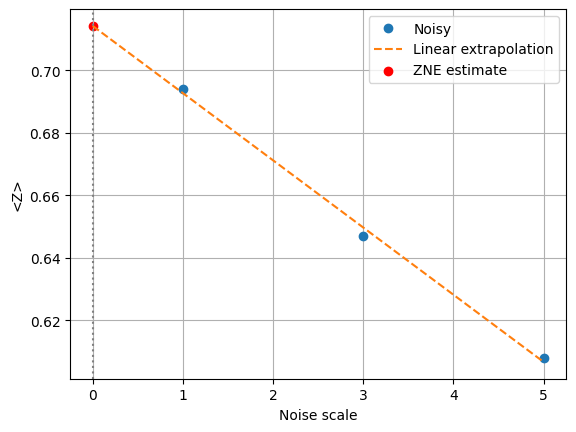

In [8]:
x_plot = np.linspace(0, max(scales), 100)
y_plot = np.polyval(coeffs, x_plot)

plt.plot(xdata, ydata, "o", label="Noisy")
plt.plot(x_plot, y_plot, "--", label="Linear extrapolation")
plt.axvline(0, linestyle=":", color="gray")
plt.scatter(0, zne_value, color="red", label="ZNE estimate")

plt.xlabel("Noise scale")
plt.ylabel("<Z>")
plt.legend()
plt.grid()
plt.show()
